In [1]:
import sys
sys.path.append("../src/")
from pinsky_rinzel_model import PinskyRinzelModel
from CA1network import CA1Network
import numpy as np
import tqdm

In [2]:
# Parameters
num_ca1 = 100              # CA1ニューロン数 (論文 Figure 9で100まで)
num_ca3_patterns = 20      # M=100 (論文では具体的な値が指定されていない)
num_ca3_patterns_input = 3 # m=3 (主成分空間の次元と一致させる)
t_interval_T = 100.0       # T=100ms (論文 Figure 4) 
duration_delta = 5.0       # delta=5ms (論文 Section 3.1) 
sim_dt = 0.05              # シミュレーションタイムステップ 
neuron_type = "bursting"
synapse_type = "BOTH"
sequence_length = 300      # 入力繰り返しの回数
t_span_network = (0, t_interval_T * sequence_length) # 0ms から 1000ms
rng = np.random.default_rng(42)
selected_numbers = rng.choice(range(num_ca3_patterns), size=num_ca3_patterns_input, replace=False)
print(selected_numbers)
ca3_input_sequence = rng.integers(0, num_ca3_patterns_input, size=sequence_length).tolist()
for input_idx in range(sequence_length):
    ca3_input_sequence[input_idx] = selected_numbers[ca3_input_sequence[input_idx]]
print(f"Generated CA3 input sequence: {ca3_input_sequence}")

[13  1 14]
Generated CA3 input sequence: [np.int64(14), np.int64(13), np.int64(14), np.int64(13), np.int64(13), np.int64(1), np.int64(14), np.int64(14), np.int64(14), np.int64(14), np.int64(14), np.int64(1), np.int64(13), np.int64(14), np.int64(1), np.int64(1), np.int64(1), np.int64(13), np.int64(14), np.int64(14), np.int64(1), np.int64(1), np.int64(14), np.int64(1), np.int64(1), np.int64(1), np.int64(13), np.int64(13), np.int64(1), np.int64(14), np.int64(13), np.int64(14), np.int64(14), np.int64(13), np.int64(1), np.int64(13), np.int64(14), np.int64(14), np.int64(1), np.int64(13), np.int64(14), np.int64(1), np.int64(14), np.int64(14), np.int64(14), np.int64(14), np.int64(13), np.int64(1), np.int64(1), np.int64(1), np.int64(13), np.int64(1), np.int64(13), np.int64(14), np.int64(14), np.int64(14), np.int64(14), np.int64(1), np.int64(14), np.int64(1), np.int64(13), np.int64(14), np.int64(1), np.int64(13), np.int64(1), np.int64(14), np.int64(13), np.int64(1), np.int64(13), np.int64(14), n

In [3]:
print(f"Initializing CA1 Network with {num_ca1} neurons...")
ca1_network = CA1Network(
    num_ca1_neurons=num_ca1,
    num_ca3_patterns=num_ca3_patterns,
    num_ca3_patterns_input=num_ca3_patterns_input,
    neuron_type=neuron_type,
    synapse_type=synapse_type,
    dt=sim_dt,
    seed=42
)
print("CA1 Network Initialized.")

Initializing CA1 Network with 100 neurons...
CA1 Network Initialized.


In [4]:
print(f"Starting network simulation for {t_span_network[1]} ms...")
network_sol = ca1_network.simulate_network(
    t_span=t_span_network,
    ca3_input_sequence=ca3_input_sequence,
    ca3_input_interval_T=t_interval_T,
    ca3_input_duration_delta=duration_delta,
)
print("Network simulation completed.")

Starting network simulation for 30000.0 ms...
Network simulation completed.


Shape of all Vs matrix: (100, 600000)


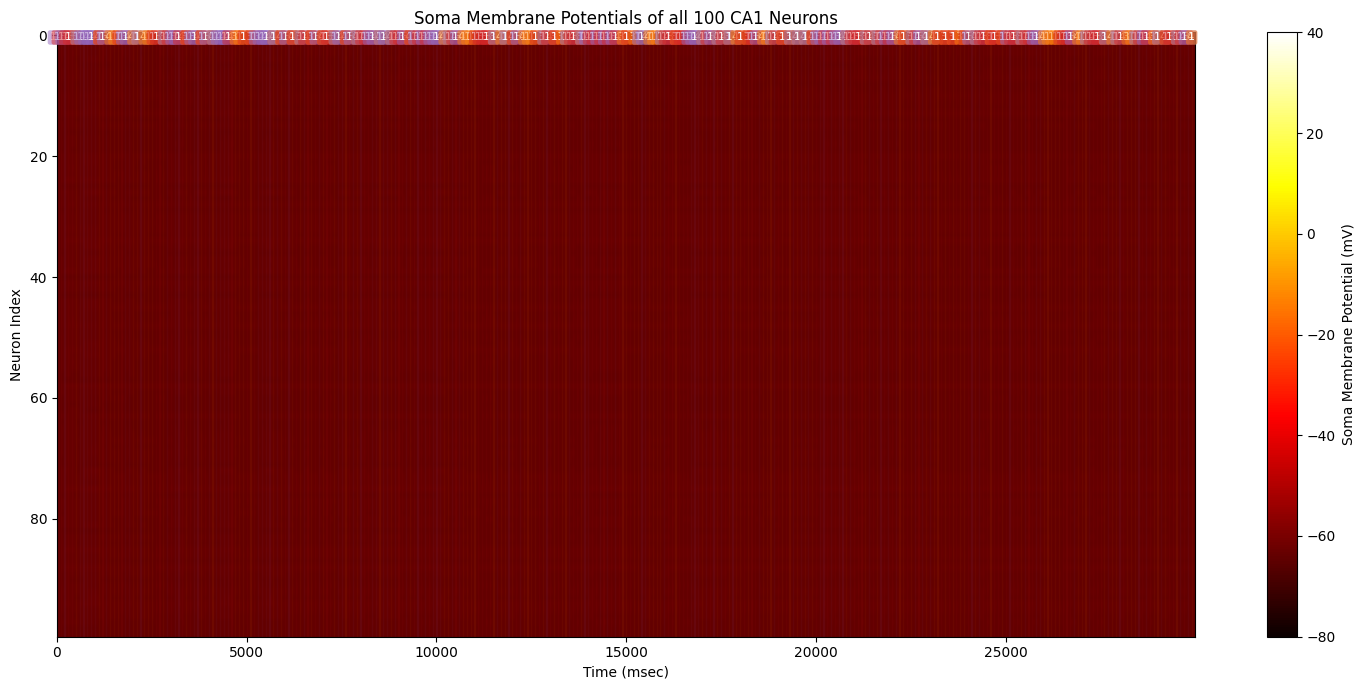

In [5]:
from matplotlib import pyplot as plt
all_vs_matrix = ca1_network.get_all_soma_membrane_potentials(network_sol)
averaged_vs_matrix = ca1_network.get_averaged_soma_potentials(network_sol, t_interval_T)
spike_counts_matrix = ca1_network.get_spike_counts(network_sol, t_interval_T)

if all_vs_matrix is not None:
    print(f"Shape of all Vs matrix: {all_vs_matrix.shape}")
    plt.figure(figsize=(15, 7))
    plt.imshow(all_vs_matrix, aspect='auto', cmap='hot',
               extent=[network_sol.t.min(), network_sol.t.max(), ca1_network.num_ca1_neurons - 0.5, -0.5],
               origin='upper', vmin=-80, vmax=40)
    plt.colorbar(label='Soma Membrane Potential (mV)')
    plt.title(f'Soma Membrane Potentials of all {ca1_network.num_ca1_neurons} CA1 Neurons')
    plt.xlabel('Time (msec)')
    plt.ylabel('Neuron Index')
    y_min_ax, y_max_ax = plt.gca().get_ylim() 
    for k_idx, pattern_idx in enumerate(ca3_input_sequence):
        start_time = k_idx * t_interval_T
        end_time = start_time + duration_delta
        plt.axvspan(start_time, end_time, color=f'C{pattern_idx}', alpha=0.05) 
        plt.text(start_time + duration_delta/2, y_max_ax * 0.95, str(pattern_idx), 
                 horizontalalignment='center', verticalalignment='top', fontsize=8, color='white',
                 bbox=dict(facecolor=f'C{pattern_idx}', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))
    plt.tight_layout()
    plt.savefig("ca1_network_all_vs_heatmap.png")
plt.show()


Starting PCA and 3D plotting (no color coding)...
Shape of data for PCA (intervals x neurons): (300, 100)
Shape of principal components: (300, 3)
Explained variance ratio: [0.83727871 0.13478449 0.02662975]
Cumulative explained variance: 0.9986929432227353
PCA 3D plot saved successfully.


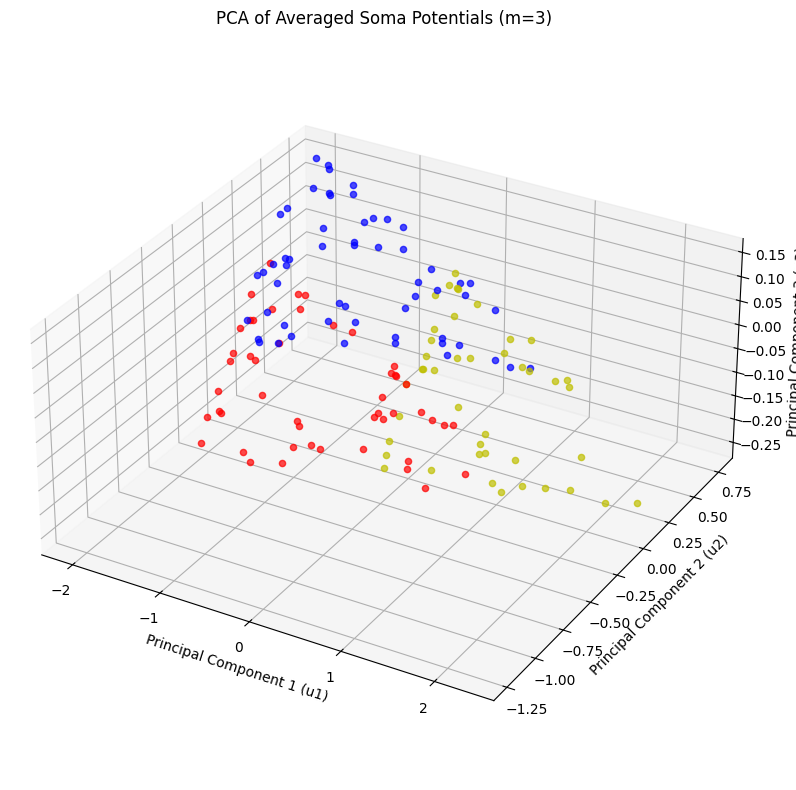

In [12]:
fig_pca = plt.figure(figsize=(10, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')

from sklearn.decomposition import PCA # PCAのために追加

print("\nStarting PCA and 3D plotting (no color coding)...")
X_pca = averaged_vs_matrix.T 
print(f"Shape of data for PCA (intervals x neurons): {X_pca.shape}")
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pca)
print(f"Shape of principal components: {principal_components.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}")
for i in range(sequence_length):
    if i > 150:
        if ca3_input_sequence[i] == selected_numbers[0]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="r",
                       s=20, alpha=0.7)
        elif ca3_input_sequence[i] == selected_numbers[1]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="b",
                       s=20, alpha=0.7)
        elif ca3_input_sequence[i] == selected_numbers[2]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="y",
                       s=20, alpha=0.7)
ax_pca.set_box_aspect((1, 1, 0.5)) 
ax_pca.set_xlabel('Principal Component 1 (u1)')
ax_pca.set_ylabel('Principal Component 2 (u2)')
ax_pca.set_zlabel('Principal Component 3 (u3)')
ax_pca.set_title(f'PCA of Averaged Soma Potentials (m={ca1_network.num_ca3_patterns_input})')
ax_pca.grid(True)
plt.tight_layout()
plt.savefig("ca1_network_pca_3d_plot.png")
print("PCA 3D plot saved successfully.")


Starting PCA and 3D plotting (no color coding)...
Shape of data for PCA (intervals x neurons): (300, 100)
Shape of principal components: (300, 3)
Explained variance ratio: [0.83727871 0.13478449 0.02662975]
Cumulative explained variance: 0.9986929432227353
PCA 3D plot saved successfully.


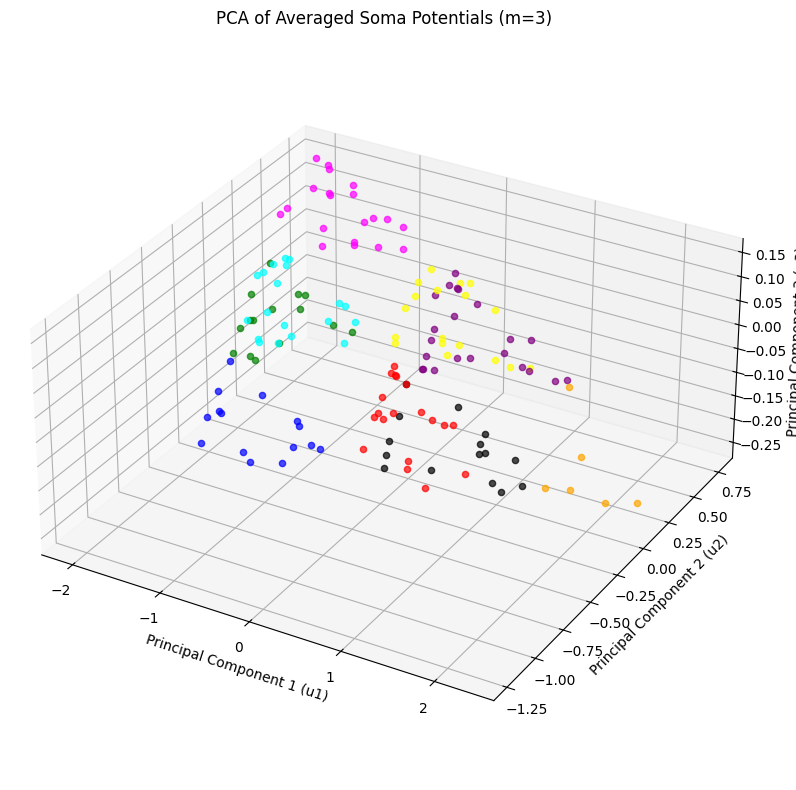

In [13]:
from sklearn.decomposition import PCA

my_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown']

fig_pca = plt.figure(figsize=(10, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')

print("\nStarting PCA and 3D plotting (no color coding)...")
X_pca = averaged_vs_matrix.T 
print(f"Shape of data for PCA (intervals x neurons): {X_pca.shape}")
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pca)
print(f"Shape of principal components: {principal_components.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}")
for i in range(sequence_length):
    if i > 150:
        for last_input_idx1 in range(3):
            for last_input_idx2 in range(3):
                if ca3_input_sequence[i] == selected_numbers[last_input_idx1]:
                    if ca3_input_sequence[i-1] == selected_numbers[last_input_idx2]:
                        ax_pca.scatter(principal_components[i, 0], 
                                       principal_components[i, 1], 
                                       principal_components[i, 2], 
                                       color=my_colors[last_input_idx1 * 3 + last_input_idx2],
                                       s=20, alpha=0.7)
ax_pca.set_box_aspect((1, 1, 0.5)) 
ax_pca.set_xlabel('Principal Component 1 (u1)')
ax_pca.set_ylabel('Principal Component 2 (u2)')
ax_pca.set_zlabel('Principal Component 3 (u3)')
ax_pca.set_title(f'PCA of Averaged Soma Potentials (m={ca1_network.num_ca3_patterns_input})')
ax_pca.grid(True)
plt.tight_layout()
plt.savefig("ca1_network_pca_3d_plot.png")
print("PCA 3D plot saved successfully.")

In [10]:
if all_vs_matrix is not None:
    output_filename = "data/all_vs_matrix.npy"
    np.save(output_filename, all_vs_matrix)
    print(f"All Vs matrix saved to {output_filename}")

All Vs matrix saved to data/all_vs_matrix.npy



Starting PCA and 3D plotting (no color coding)...
Shape of data for PCA (intervals x neurons): (300, 100)
Shape of principal components: (300, 3)
Explained variance ratio: [nan nan nan]
Cumulative explained variance: nan


/home/satoshi/Yamaguti_etal_2011/venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


PCA 3D plot saved successfully.


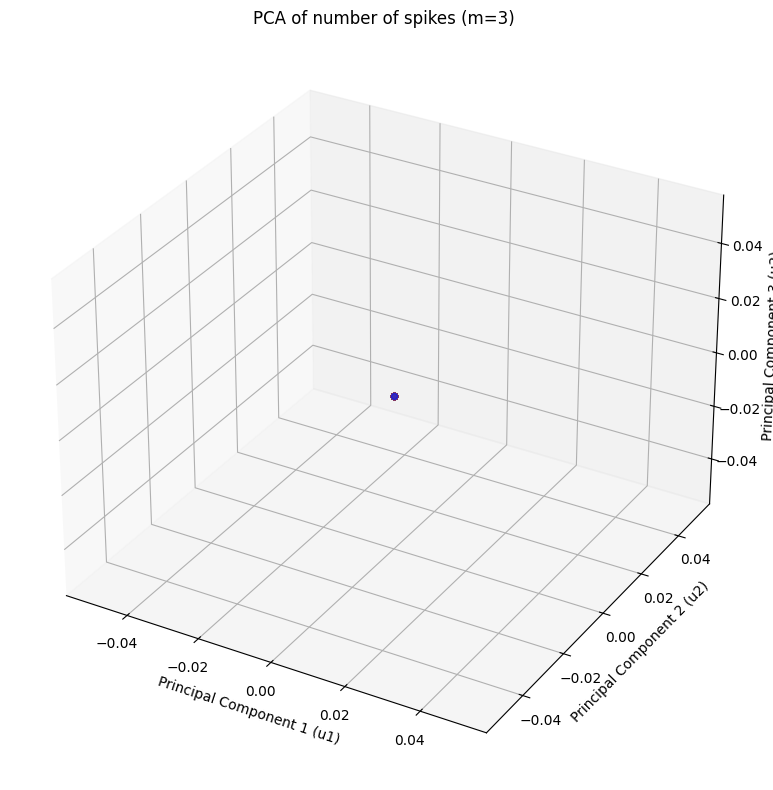

In [11]:
fig_pca = plt.figure(figsize=(10, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')

print("\nStarting PCA and 3D plotting (no color coding)...")
X_pca = spike_counts_matrix.T
print(f"Shape of data for PCA (intervals x neurons): {X_pca.shape}")
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pca)
print(f"Shape of principal components: {principal_components.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}")
for i in range(sequence_length):
    if i > 150:
        if ca3_input_sequence[i] == selected_numbers[0]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="r",
                       s=20, alpha=0.7)
        elif ca3_input_sequence[i] == selected_numbers[1]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="b",
                       s=20, alpha=0.7)
        elif ca3_input_sequence[i] == selected_numbers[2]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="y",
                       s=20, alpha=0.7)

ax_pca.set_xlabel('Principal Component 1 (u1)')
ax_pca.set_ylabel('Principal Component 2 (u2)')
ax_pca.set_zlabel('Principal Component 3 (u3)')
ax_pca.set_title(f'PCA of number of spikes (m={ca1_network.num_ca3_patterns_input})')
ax_pca.grid(True)
plt.tight_layout()
plt.savefig("ca1_network_pca_3d_plot.png")
print("PCA 3D plot saved successfully.")

In [ ]:
from sklearn.decomposition import PCA

my_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown']

fig_pca = plt.figure(figsize=(10, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')

print("\nStarting PCA and 3D plotting (no color coding)...")
X_pca = spike_counts_matrix.T 
print(f"Shape of data for PCA (intervals x neurons): {X_pca.shape}")
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pca)
print(f"Shape of principal components: {principal_components.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}")
for i in range(sequence_length):
    if i > 150:
        for last_input_idx1 in range(3):
            for last_input_idx2 in range(3):
                if ca3_input_sequence[i] == selected_numbers[last_input_idx1]:
                    if ca3_input_sequence[i-1] == selected_numbers[last_input_idx2]:
                        ax_pca.scatter(principal_components[i, 0], 
                                       principal_components[i, 1], 
                                       principal_components[i, 2], 
                                       color=my_colors[last_input_idx1 * 3 + last_input_idx2],
                                       s=20, alpha=0.7)

ax_pca.set_xlabel('Principal Component 1 (u1)')
ax_pca.set_ylabel('Principal Component 2 (u2)')
ax_pca.set_zlabel('Principal Component 3 (u3)')
ax_pca.set_title(f'PCA of number of spikes (m={ca1_network.num_ca3_patterns_input})')
ax_pca.grid(True)
plt.tight_layout()
plt.savefig("ca1_network_pca_3d_plot.png")
print("PCA 3D plot saved successfully.")